# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
%reload_ext autoreload

In [2]:
#!pip install sqlalchemy -q

#!pip install --upgrade ipython-sql sqlalchemy -q

!pip install scikit-learn==1.1.3 -q

!pip install catboost -q

!pip install pandas spacy scikit-learn -q

!python -m spacy download en_core_web_sm -q

!pip install pydantic==1.7.4 -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.linear_model import(
    Ridge,
    LinearRegression,
    LogisticRegression
)

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer
)

    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from pymystem3 import Mystem
import re


import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.corpus import stopwords

import torch
import transformers


RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка

In [4]:
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', sep=',')
    
except:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', sep=',')

In [5]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
toxic_comments.describe(include='all')

,Unnamed: 0,text,toxic
count,159292.000000,159292,159292.000000
unique,NaN,159292,NaN
top,NaN,User page\nHey I'm real sorry. I saw red link ...,NaN
freq,NaN,1,NaN
mean,79725.697242,NaN,0.101612
std,46028.837471,NaN,0.302139
min,0.000000,NaN,0.000000
25%,39872.750000,NaN,0.000000
50%,79721.500000,NaN,0.000000
75%,119573.250000,NaN,0.000000


In [7]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Выведем долю пропущенных значений для каждого столбца датафреймов.

In [8]:
pd.DataFrame(toxic_comments.isna().mean()*100)

,0
Unnamed: 0,0.0
text,0.0
toxic,0.0


Пропущенных значений не обнаружено.

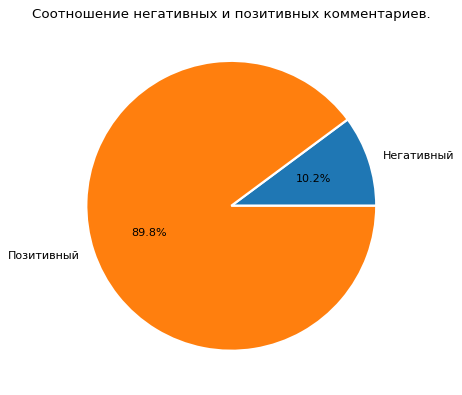

In [9]:
n1 = toxic_comments[toxic_comments['toxic'] == 1]['text'].count()
n2 = toxic_comments[toxic_comments['toxic'] == 0]['text'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['Негативный', 'Позитивный'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Соотношение негативных и позитивных комментариев.')
plt.show()

Признак toxic является целевым, он показывает эмоциональную окраску комментария. Из диаграммы видно, что около 90% комментариев являются позитивными и только 10% - негативными. Имеется дисбалланс классов, который необходимо учесть при разбивке на тренировочную и тестовую выборки.

Напишем функцию, которая переводит текст в нижний регистр и кодировку Unicode U.

In [11]:
def prepare_text(text):
    lower_text = text.lower()
    
    return pd.Series([lower_text])

In [12]:
toxic_comments['text'] = toxic_comments['text'].apply(prepare_text)

In [13]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,explanation\nwhy the edits made under my usern...,0
1,1,d'aww! he matches this background colour i'm s...,0
2,2,"hey man, i'm really not trying to edit war. it...",0
3,3,"""\nmore\ni can't make any real suggestions on ...",0
4,4,"you, sir, are my hero. any chance you remember...",0


Напишем функцию, которая оставит в тексте только латинские символы и пробелы, а также уберет лишние пробелы.

In [14]:
def clear_text(text):
    t = re.sub(r'[^a-z]', ' ', text)
    t1 = t.split()
    return " ".join(t1)

In [15]:
toxic_comments['text'] = toxic_comments['text'].apply(clear_text)

In [16]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he matches this background colour i m se...,0
2,2,hey man i m really not trying to edit war it s...,0
3,3,more i can t make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0


Проведем предобработку текста - лемматизацию. Лемматизация (англ. lemmatization) — приведение слова к начальной форме (лемме).
Для лемматизации используем NLTK (Natural Language Toolkit) — одну из самых популярных библиотек для обработки естественного языка.

spaCy — современная библиотека для NLP, которая также предоставляет возможности для лемматизации. Используем модель en_core_web_sm для английского языка. Нам нужен только лемматизатор, поэтому отключим ненужные компоненты.

In [17]:
# Загружаем модель spaCy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

Напишем функцию для лемматизации текста. Функция lemmatize_text выполняет лемматизацию и исключает стоп-слова и знаки препинания.

In [18]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(lemmas)

In [19]:
toxic_comments['lemmatized_text'] = toxic_comments['text'].apply(lemmatize_text)

In [20]:
toxic_comments.head()

,Unnamed: 0,text,toxic,lemmatized_text
0,0,explanation why the edits made under my userna...,0,explanation edit username hardcore metallica f...
1,1,d aww he matches this background colour i m se...,0,d aww match background colour m seemingly stuc...
2,2,hey man i m really not trying to edit war it s...,0,hey man m try edit war s guy constantly remove...
3,3,more i can t make any real suggestions on impr...,0,t real suggestion improvement wonder section s...
4,4,you sir are my hero any chance you remember wh...,0,sir hero chance remember page s


Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Вычислим TF-IDF для корпуса текстов. Создадим счётчик TF-IDF. Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform().

## Обучение

Выделим целевой признак. Разобьем выборку на обучающую и тестовую.

In [23]:
Y = toxic_comments['toxic']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(toxic_comments['lemmatized_text'], Y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify = Y)

Перед подбором параметров модели определимся с типами моделей, которые будем использовать. Посмотрим на линейную модель и бустинг.

In [25]:
vectorizer = TfidfVectorizer()

In [26]:
X_train_matrix = vectorizer.fit_transform(X_train)

In [27]:
X_test_matrix = vectorizer.transform(X_test)

In [28]:
model_lin = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2', C=10.0)

In [29]:
model_lin.fit(X_train_matrix, y_train)

LogisticRegression(C=10.0, random_state=42, solver='liblinear')

In [30]:
y_pred_lin = model_lin.predict(X_train_matrix)

In [31]:
f1_lin = f1_score(y_train, y_pred_lin)

In [32]:
print('Метрика модели на тренировочной выборке:', f1_lin)

Метрика модели на тренировочной выборке: 0.9102854159415245


Обучим еще одну модель - CatBoost , также использующую градиентный бустинг на деревьях решений.

In [33]:
model_cat = CatBoostClassifier(iterations=900, learning_rate=0.1, depth=6)

In [34]:
model_cat.fit(X_train_matrix, y_train)

0:	learn: 0.5923048	total: 2.64s	remaining: 39m 35s
1:	learn: 0.5118358	total: 4.63s	remaining: 34m 40s
2:	learn: 0.4501216	total: 6.69s	remaining: 33m 21s
3:	learn: 0.4027902	total: 8.77s	remaining: 32m 44s
4:	learn: 0.3653856	total: 10.8s	remaining: 32m 14s
5:	learn: 0.3361261	total: 12.8s	remaining: 31m 43s
6:	learn: 0.3131992	total: 14.8s	remaining: 31m 25s
7:	learn: 0.2962652	total: 16.8s	remaining: 31m 8s
8:	learn: 0.2822124	total: 18.7s	remaining: 30m 52s
9:	learn: 0.2708762	total: 20.7s	remaining: 30m 44s
10:	learn: 0.2602984	total: 22.8s	remaining: 30m 42s
11:	learn: 0.2525114	total: 24.8s	remaining: 30m 33s
12:	learn: 0.2461572	total: 26.8s	remaining: 30m 27s
13:	learn: 0.2409250	total: 28.7s	remaining: 30m 15s
14:	learn: 0.2360525	total: 30.7s	remaining: 30m 13s
15:	learn: 0.2324505	total: 32.7s	remaining: 30m 6s
16:	learn: 0.2273317	total: 34.7s	remaining: 30m 2s
17:	learn: 0.2243793	total: 36.7s	remaining: 29m 57s
18:	learn: 0.2221436	total: 38.6s	remaining: 29m 48s
19:	le

In [35]:
y_pred_cat = model_cat.predict(X_train_matrix)

In [36]:
f1_cat = f1_score(y_train, y_pred_cat)

In [37]:
print('Метрика модели на тренировочной выборке:', f1_cat)

Метрика модели на тренировочной выборке: 0.8105461393596988


Для оценки моделей по условию задачи будем использовать  метрику f1 - гармоническое среднее между точностью и полнотой (precision и recall).

На тренировочной выборке лучший результат показала LogisticRegression. Для нее значение метрики f1 составило 0,91, что отвечает условиям задачи. Поэтому при подборе параметров и использовании кросс-валидации возьмем LogisticRegression и KNeighborsClassifier.

Используем Pipeline.

In [38]:
pipe_final= Pipeline(
    [
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('models', LogisticRegression())
    ]
)

param_grid = [
    # словарь для модели CatBoostClassifier()
    #{
        #'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        #'models__depth': range(5, 7),
        #'models__iterations': range(900, 1000),
        #'models__learning_rate': np.arange(0.01, 0.02),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    #},
    
     # словарь для модели LinearRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': range(6, 11)  
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 10)   
    },
   
    
    ]

In [39]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3, 
    scoring='f1',
    error_score='raise',
    n_jobs=-1
)

In [40]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('models', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(C=10,
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(6, 11)},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(5, 10)}],
                   scoring='f1')

In [41]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('models',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])


In [42]:
print(randomized_search.best_params_)

{'models__C': 10, 'models': LogisticRegression(C=10, random_state=42, solver='liblinear')}


In [43]:
#print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

In [44]:
best_model = randomized_search.best_estimator_

In [45]:
y_pred = best_model.predict(X_train)

In [46]:
f1_train = f1_score(y_train, y_pred)

In [47]:
print('Метрика лучшей модели на тренировочной выборке:', f1_train)

Метрика лучшей модели на тренировочной выборке: 0.9102854159415245


In [48]:
y_pred_test = best_model.predict(X_test)

In [49]:
f1_test = f1_score(y_test, y_pred_test)

In [50]:
print('Метрика лучшей модели на тестовой выборке:', f1_test)

Метрика лучшей модели на тестовой выборке: 0.7779922779922781


## Выводы

Для анализа нам дан датафрейм с комментариями на английском языке и их эмоциональной оценкой (0/1), которая является целевым признаком. Около 90% комментариев являются позитивными и только 10% - негативными. Имеется дисбалланс классов, который необходимо учесть при разбивке на тренировочную и тестовую выборки.

Всего в датафрейме 159292 строки, пропусков нет.

В процессе обработки текст приведен к нижнему регистру. В тексте  оставлены только латинские символы и пробелы.
Проведена предобработка текста - лемматизация. Лемматизация (англ. lemmatization) — приведение слова к начальной форме (лемме). Для лемматизации используем NLTK (Natural Language Toolkit) — одну из самых популярных библиотек для обработки естественного языка.
Также используем spaCy — современную библиотеку для NLP, которая также предоставляет возможности для лемматизации. Используем модель en_core_web_sm для английского языка.

Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе. Вычислим TF-IDF для корпуса текстов. Создадим счётчик TF-IDF. 

Оценить тональность — значит отметить текст как позитивный или негативный. То есть, будем решать задачу классификации, где целевой признак равен «1» для негативного текста и «0» для позитивного. Признаки — это слова из корпуса и их величины TF-IDF для каждого текста.

Для оценки моделей по условию задачи будем использовать метрику f1 - гармоническое среднее между точностью и полнотой (precision и recall). При подборе параметров и использовании кросс-валидации возьмем в качестве моделей LogisticRegression и KNeighborsClassifier.

В результате определения лучшей модели оказалось, что лучшее значение на тренировочной выборке показала модель LogisticRegression(C=10, random_state=42, solver='liblinear'). Метрика f1 на тестовой выборке - 0.78.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны